# **Distributed Spectral Decomposition in Networks by Complex Diffusion and Quantum Random Walk**



# Names :

## - AMRADOUCH Ali Anass
## - Mohammed Amine MAFTOUH

# Libraries

In [ ]:
install.packages('ggplot2')
install.packages("igraph")
library("igraph")
library("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




# Some Practical applications :

##***Triangle Counting in Graphs***

- **Measure robustness**: In a triangle, even if one connection is cut, an alternative path exists, which is crucial for networks like transportation systems.
- **Detect communities**: Identifies densely connected regions, aiding in community detection and analysis.


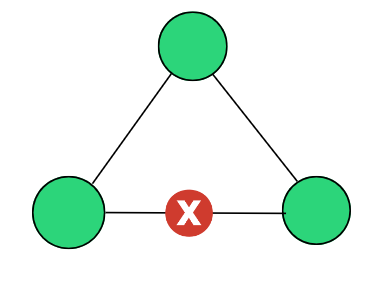

### ***Triangle Counting Using the Adjacency Matrix***

$ - \text{The } (i, j) \text{-entry of } A^k \text{ represents the number of walks of length } k \text{ from node } i \text{ to node } j. \text{ This is because matrix multiplication accumulates all paths of length } k \text{ by summing over all intermediate nodes.} $

$ - \text{Specifically, } A^3[i, i] \text{ counts the number of walks of length 3 starting and ending at node } i. \text{ These walks correspond to closed paths, which define triangles in the graph.} $

### **Example : Three traingles graph**

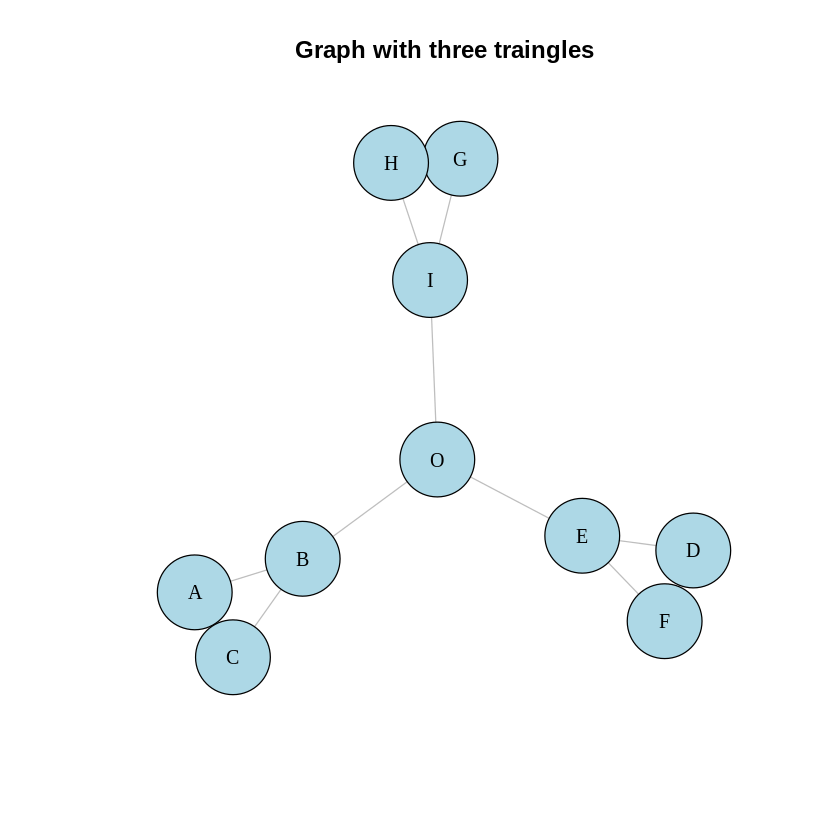

In [ ]:
g <- graph_from_literal(
  A-B, B-C, C-A,
  D-E, E-F, F-D,
  G-H, H-I, I-G,
  B-O, E-O, I-O
)

plot(g, vertex.size=30, vertex.color="lightblue", vertex.label.color="black",
     edge.color="gray", main="Graph with three traingles",
     layout = layout_with_fr(g))

### **Number of traingles**

In [ ]:
# Adjacency matrix
A <- as_adjacency_matrix(g)

# eigenvalues of A
eigenvalues <- eigen(A)$values
print(eigenvalues)

# Nmbr of triangles
triangles <- sum(eigenvalues^3) / 6

# Affichage du résultat
print(paste("Number of triangles", triangles))

 [1]  2.5141369  2.0000000  2.0000000  0.5719933 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000 -1.0000000 -2.0861302
[1] "Number of triangles 3.00000000000002"


### **Number of traingles where B is involved ( with 3 highest eigenvalues )**

In [ ]:
# Décomposer la matrice d'adjacence
eig <- eigen(A)
lambda <- eig$values
U <- eig$vectors

k <- 3
lambda_k <- lambda[1:k]
U_k <- U[, 1:k]

node_index <- which(V(g)$name == "B")
T_B_approx <- 0.5 * sum((abs(lambda_k)^3) * U_k[node_index, ])
T_B_approx

[1] 1.108859

## Dimensionality Reduction using Eigenvalues

**When analyzing graphs, it's often useful to reduce the dimensionality of the data to focus on the most important relationships.**

$$
\text{Using the } k \text{ largest eigenvalues, the projection into } \mathbb{R}^k \text{ allows us to capture the important relationships of the graph with fewer dimensions.}
$$



# Central idea

##Classical Methods

One of the classical methods is described below:

### Power Iteration
$$
\mathbf{b}_{\ell+1} = \frac{1}{\|\mathbf{b}_\ell\|} \mathbf{A} \mathbf{b}_\ell \implies
\lambda_1 = \lim_{k \to \infty} \frac{\mathbf{b}_k^\top \mathbf{b}_{k+1}}{\|\mathbf{b}_k\|}, \quad
\mathbf{u}_1 = \lim_{k \to \infty} \frac{\mathbf{b}_k}{\|\mathbf{b}_k\|}
$$

**Drawback:** Only principal components, requires orthonormalization.

### Inverse Iteration Method
$$
\mathbf{b}_{\ell+1} = \frac{1}{\|\mathbf{b}_\ell\|} (\mathbf{A} - \mu \mathbf{I})^{-1} \mathbf{b}_\ell \implies
\text{Closest eigenvalue to } \mu: \lim_{k \to \infty} \mu + \frac{\|\mathbf{b}_k\|}{\mathbf{b}_k^\top \mathbf{b}_{k+1}}
$$

$$
\text{Eigenvector: } \lim_{k \to \infty} \frac{\mathbf{b}_k}{\|\mathbf{b}_k\|}
$$

**Drawback:** Requires inverse calculation, orthonormalization.

---

## Objective
The objective is to propose a new distributed method to compute the eigenvalues.

###Gaussian Smoothing Idea


$$
\text{Since } \mathbf{A} \text{ is symmetric, it can be written as:}
$$

$$
\mathbf{A} = \sum_{j=1}^n \lambda_j \mathbf{u}_j \mathbf{u}_j^\top,
$$

$$
\text{where } \lambda_j \text{ are the eigenvalues, and } \mathbf{u}_j \text{ are the eigenvectors of } \mathbf{A}.
$$

$$
\text{This decomposition allows us to express } e^{i\mathbf{A}t} \text{ as:}
$$

$$
e^{i\mathbf{A}t} = \sum_{j=1}^n e^{i\lambda_j t} \mathbf{u}_j \mathbf{u}_j^\top.
$$

$$
\text{Substituting this expression into the Gaussian smoothing integral and simplifying gives:}
$$

$$
\frac{1}{2\pi} \int_{-\infty}^{+\infty} e^{i\mathbf{A}t} \mathbf{b}_0 e^{-t^2 \nu / 2} e^{-i t \theta} \, dt
= \sum_{j=1}^n \frac{1}{\sqrt{2\pi \nu}}
\exp\left( -\frac{(\lambda_j - \theta)^2}{2\nu} \right)
\mathbf{u}_j (\mathbf{u}_j^\top \mathbf{b}_0).
$$


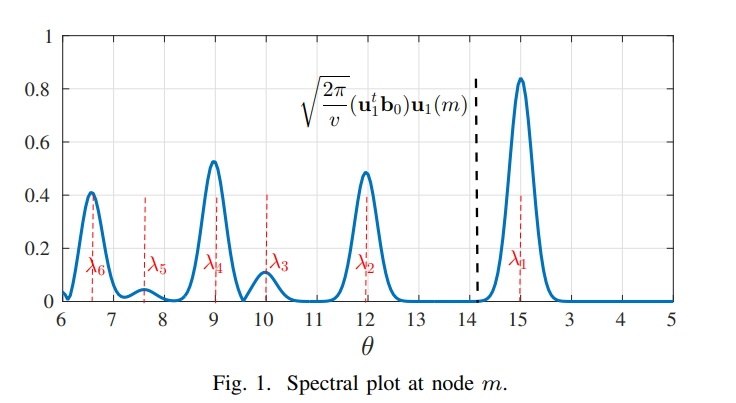


$$
\text{The goal now is to find a formula that does not depend on the eigenvectors } \mathbf{u}_j \text{ and eigenvalues } \lambda_j, \text{ and to obtain the trace of } f_\theta.
$$


$$
\int_{-\infty}^{+\infty} e^{iA t} e^{-t^2 v / 2} e^{-i t \theta} \, dt
= \varepsilon \mathfrak{R} \left( \mathbf{I} + 2 \sum_{\ell=1}^{d_{\text{max}}} \left( \mathbf{I} + i\varepsilon \mathbf{A} \right)^\ell e^{-i\ell\varepsilon \theta} e^{-\ell^2 \varepsilon^2 v / 2} \right) + O(\varepsilon^2 d_{\text{max}})
$$

$$
\text{The quantity } \mathbfϵ\ell \text{ in the sum plays the role of the variable } t.
$$


$$
f_\theta = \varepsilon \mathfrak{R} \left( \mathbf{b}_0 + 2 \sum_{\ell=1}^{d_{\text{max}}} e^{-i\ell\varepsilon\theta} e^{-\ell^2 \varepsilon^2 v / 2} \mathbf{x}_\ell \right)
$$

$$
\text{where } \mathbf{x}_\ell \text{ is the approximation of } e^{i\ell\varepsilon \mathbf{A}} \mathbf{b}_0.
$$

$$
\text{Now, the focus is on computing either } \mathbf{x}_\ell \text{ or the term in the sum } \sum_{\ell=1}^{d_{\text{max}}} e^{-i\ell\varepsilon\theta} e^{-\ell^2 \varepsilon^2 v / 2} \mathbf{x}_\ell.
$$


$$
\text{We now resort to the use of the Complex Diffusion algorithm  which is designed to iteratively approximate the required terms in the summation } \mathbf{x}_\ell.
$$

# 1/ Complex diffusion algorithm

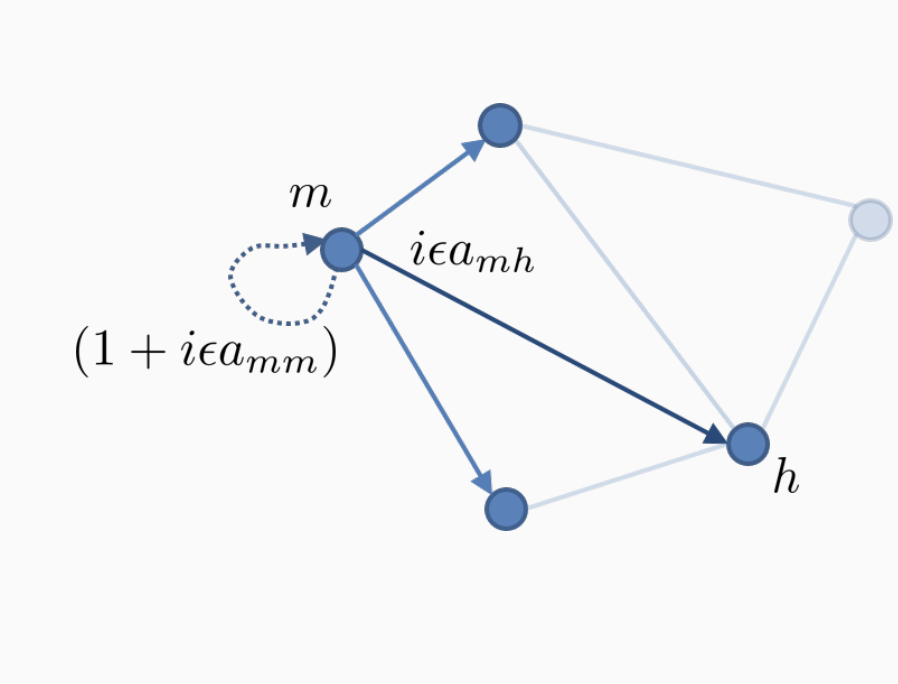

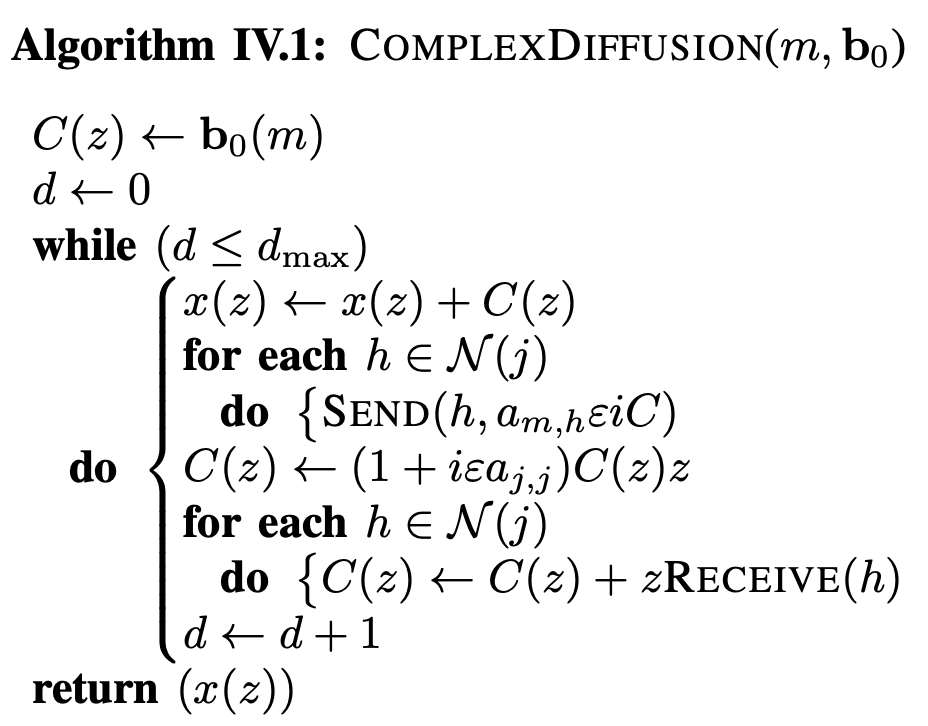

In [ ]:
n <- vcount(g) # Get the actual number of vertices in the graph g
m <- 2

g <- graph_from_literal(
  A-B, B-C, C-A,
  D-E, E-F, F-D,
  G-H, H-I, I-G,
  B-O, E-O, I-O
)
A <- as.matrix(as_adjacency_matrix(g))

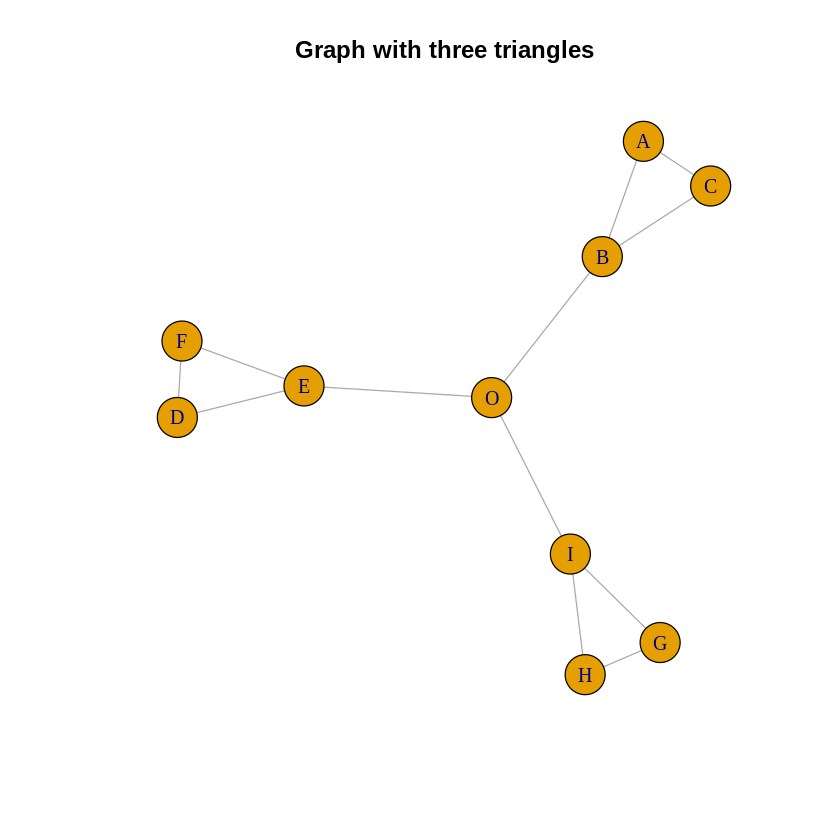

In [ ]:
plot(g,main = "Graph with three triangles",layout = layout_with_fr)

# **Procedure to Find the Eigenvalues of A**

## Step 1: Initialization

$$
- \text{Define the hyperparameters: } \epsilon, d_{\text{max}}, \nu.
$$
$$
- \text{Select the node } m \text{ and an initial vector } \mathbf{b}_0.
$$
$$
- \text{Create a sequence of } \theta \text{ values.}
$$

## Step 2: Computation

$$
- \text{Apply the Complex Diffusion Algorithm to compute the polynomial } x_l
$$
$$
- \text{Calculate } f(\theta).
$$

## Step 3: Iteration and Identification

$$
- \text{Iterate over the sequence of } \theta \text{ to compute and plot } f(\theta).
$$
$$
- \text{Identify the peaks in } f(\theta), \text{ which correspond to the eigenvalues.}
$$

### Parameters

In [ ]:
#combinaisons spécifiques de paramètres
combinations <- list(
  list(dmax = 10000, epsilon = 0.1, nu = 0.1),
  list(dmax = 1500, epsilon = 0.02, nu = 0.1),
  list(dmax = 1500, epsilon = 0.02, nu = 0.001),
  list(dmax = 10000, epsilon = 0.1, nu = 0.001)

)

## Complex Diffusion Algorithm

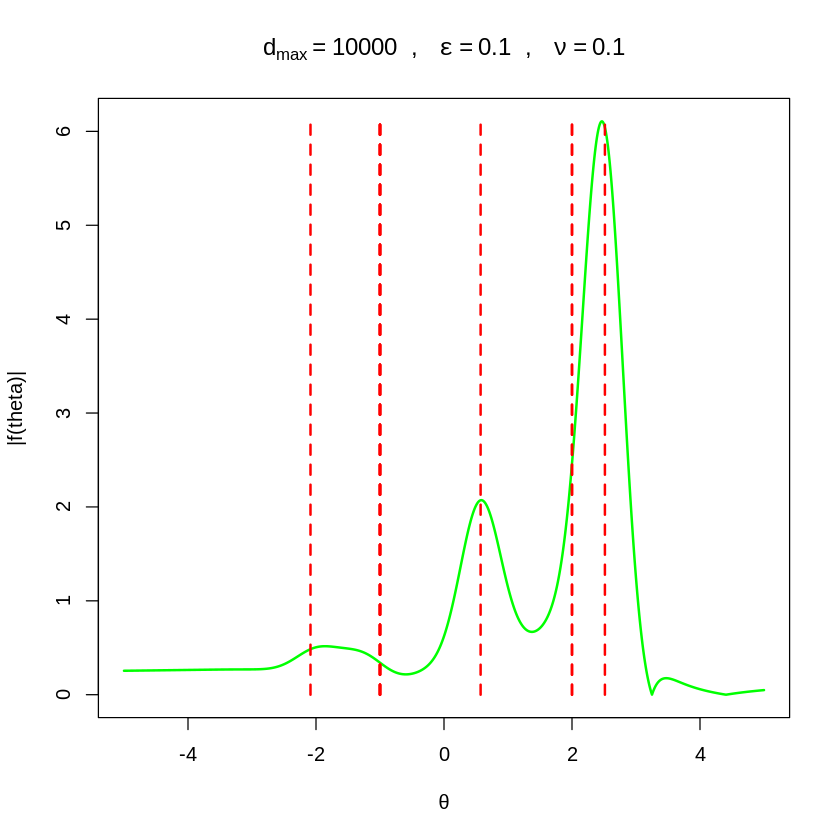

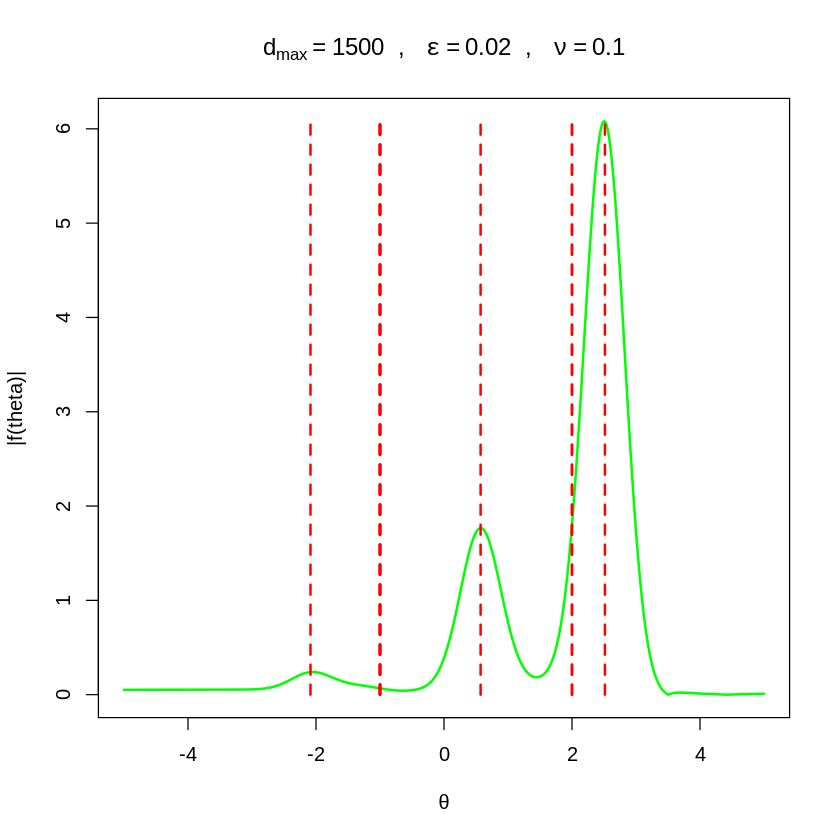

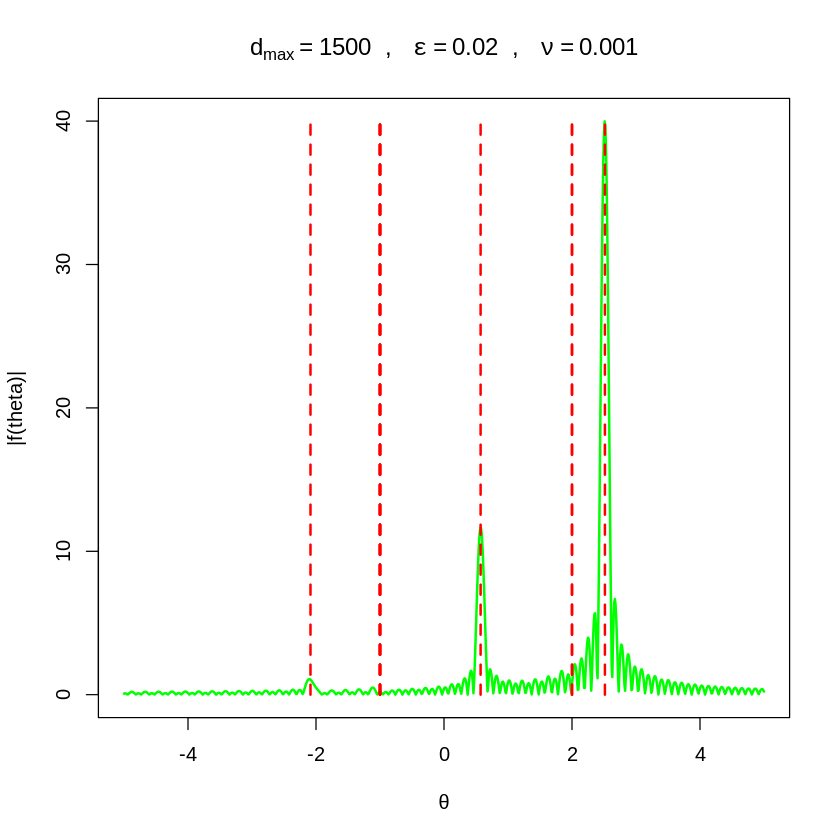

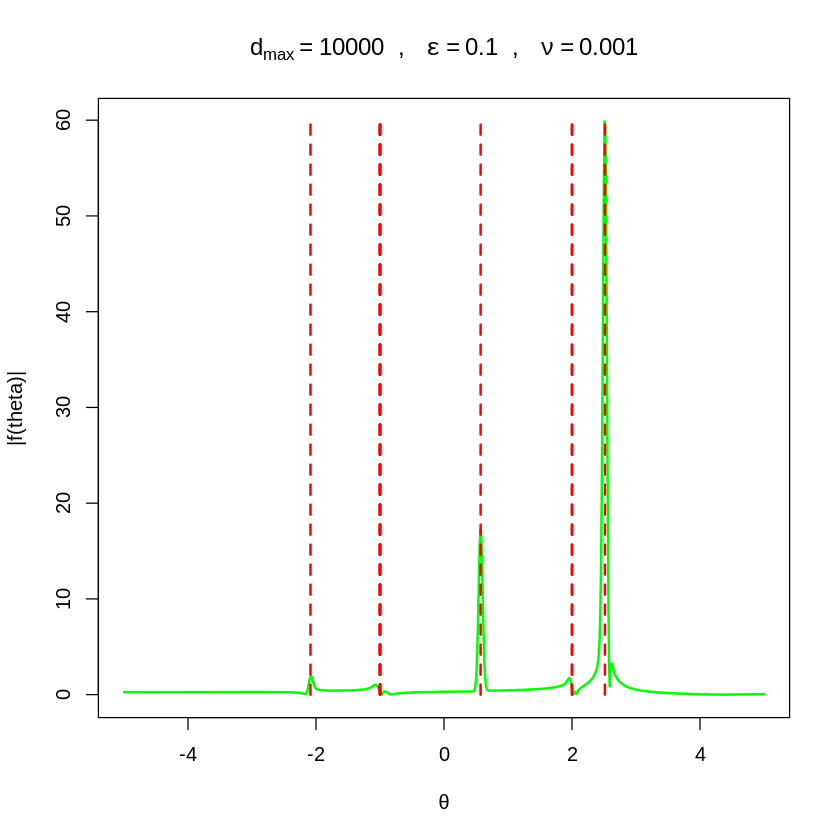

In [ ]:
# Complex Diffusion Method

for (params in combinations) {
  current_dmax <- params$dmax
  epsilon <- params$epsilon
  nu <- params$nu

  b0 <- rep(1, n)
  x <- vector("list", n)
  for (m in 1:n) {
    x[[m]] <- rep(0, current_dmax + 1)
    x[[m]][1] <- b0[m]
  }

  C <- vector("list", n)
  for (m in 1:n) {
    C[[m]] <- b0[m]
  }

  for (d in 1:current_dmax) {
    for (m in 1:n) {
      for (h in which(A[m, ] != 0)) {
        C[[h]] <- C[[h]] + (1i * epsilon * A[m, h] * C[[m]])
      }
      C[[m]] <- (1 + 1i * epsilon * A[m, m]) * C[[m]]
      x[[m]][d + 1] <- C[[m]]
    }
  }

  # f(theta)
  f_theta <- function(m, theta) {
    f_val <- 0 + 0i
    for (l in 1:(current_dmax + 1)) {
      f_val <- f_val + 2 * exp(-1i * (l - 1) * epsilon * theta) *
        exp(-(l - 1)^2 * epsilon^2 * nu / 2) * x[[m]][l]
    }
    return(epsilon * (Re(b0[m] + f_val)))
  }

  theta_fine <- seq(-5, 5, by = 0.01)
  y_theta_fine <- sapply(theta_fine, function(th) f_theta(4, th))

  # Plot the magnitude of f(theta)
  plot(theta_fine, abs(y_theta_fine), type = "l", col = "green", lwd = 2,
       xlab = expression(theta), ylab = "|f(theta)|",
       main = bquote(d[max] == .(current_dmax) ~ ", " ~ epsilon == .(epsilon) ~ ", " ~ nu == .(nu)))

  # Plot vertical lines at eigenvalue positions in red
  eigenvalues <- eigen(A)$values
  # Tracer les lignes verticales pointillées aux positions des valeurs propres
  for (ev in eigenvalues) {
    # Tracer des lignes pointillées du bas (y = 0) vers le haut (hauteur max de la figure)
    segments(ev, 0, ev, abs(max(abs(y_theta_fine))), col = "red", lwd = 2, lty = 2)
  }
}

## Peaks of f(theta)

[1] "Theta values where f(theta) is maximal and above threshold:"
[1] -2.08 -1.08  0.57  1.96  2.51
[1] "Corresponding f(theta) values:"
[1]  1.926700  1.033321 17.258868  1.748562 59.879862


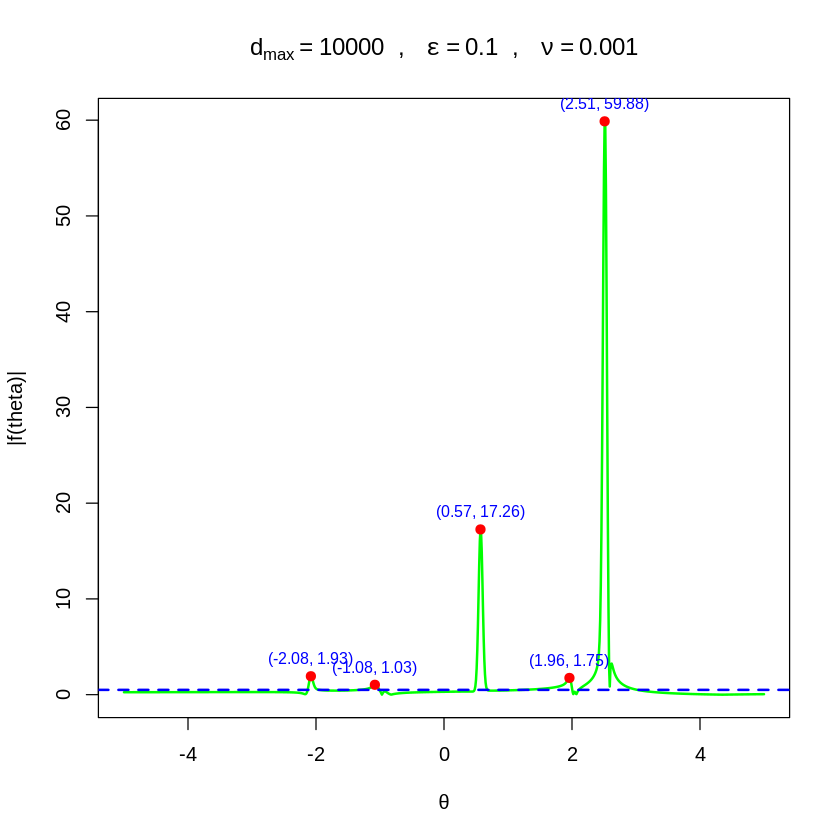

In [ ]:
find_peaks_above_threshold <- function(theta_fine, y_theta_fine, threshold, min_distance) {
  peaks_indices <- which(diff(sign(diff(abs(y_theta_fine)))) == -2) + 1

  peaks_theta <- theta_fine[peaks_indices]
  peaks_values <- y_theta_fine[peaks_indices]

  valid_peaks <- which(peaks_values > threshold)
  peaks_theta <- peaks_theta[valid_peaks]
  peaks_values <- peaks_values[valid_peaks]

  selected_indices <- c()
  for (i in seq_along(peaks_theta)) {
    if (length(selected_indices) == 0 || abs(peaks_theta[i] - peaks_theta[selected_indices[length(selected_indices)]]) > min_distance) {
      selected_indices <- c(selected_indices, i)
    }
  }

  return(list(peaks_theta = peaks_theta[selected_indices],
              peaks_values = peaks_values[selected_indices]))
}

# seuils
threshold_value <- 0.5
min_distance <- 0.3  # Distance minimale entre deux pics

#les pics avec les seuils spécifiés
peaks <- find_peaks_above_threshold(theta_fine, abs(y_theta_fine), threshold_value, min_distance)

print("Theta values where f(theta) is maximal and above threshold:")
print(peaks$peaks_theta)
print("Corresponding f(theta) values:")
print(peaks$peaks_values)

#la fonction et les pics
plot(theta_fine, abs(y_theta_fine), type = "l", col = "green", lwd = 2,
     xlab = expression(theta), ylab = "|f(theta)|",
     main = bquote(d[max] == .(current_dmax) ~ ", " ~ epsilon == .(epsilon) ~ ", " ~ nu == .(nu)))

points(peaks$peaks_theta, peaks$peaks_values, col = "red", pch = 19)

for (i in seq_along(peaks$peaks_theta)) {
  text(peaks$peaks_theta[i], peaks$peaks_values[i],
       labels = paste("(", round(peaks$peaks_theta[i], 2), ", ", round(peaks$peaks_values[i], 2), ")", sep = ""),
       pos = 3, cex = 0.8, col = "blue")
}

abline(h = threshold_value, col = "blue", lty = 2, lwd = 2)


In [ ]:
peaks

$peaks_theta
[1] -2.08 -1.08  0.57  1.96  2.51

$peaks_values
[1]  1.926700  1.033321 17.258868  1.748562 59.879862

# Application : Triangles Counting

In [ ]:
# Nmbr of triangles
triangles <- sum(peaks$peaks_theta^3) / 6

print(paste("Number of triangles", triangles))

[1] "Number of triangles 2.21155933333333"
